In [1]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.2 MB/s eta 0:00:00


In [2]:
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import string
import torch
import re
import sklearn
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Pre-processing

In [4]:
train = pd.read_json("train.jsonl",lines=True)
dev = pd.read_json("dev.jsonl",lines=True)
train.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [5]:
del train['id']
del train['img']
train.head()

,label,text
0,0,its their character not their color that matters
1,0,don't be afraid to love again everyone is not ...
2,0,putting bows on your pet
3,0,i love everything and everybody! except for sq...
4,0,"everybody loves chocolate chip cookies, even h..."


In [6]:
del dev['id']
del dev['img']
dev.head()

,label,text
0,1,white people is this a shooting range
1,1,bravery at its finest
2,1,your order comes to $37.50 and your white priv...
3,1,it is time.. to send these parasites back to t...
4,1,mississippi wind chime


In [7]:
# function to remove the punctuation

def punctuation(df, column, new_column):
  df[new_column]=df[column].apply(lambda x: "".join([char for char in x if char not in string.punctuation]))
  return df


In [8]:
cleaned_train = punctuation(train, 'text', 'cleaned_text')
del cleaned_train['text']
cleaned_train.head()

,label,cleaned_text
0,0,its their character not their color that matters
1,0,dont be afraid to love again everyone is not l...
2,0,putting bows on your pet
3,0,i love everything and everybody except for squ...
4,0,everybody loves chocolate chip cookies even hi...


In [9]:
cleaned_dev = punctuation(dev, 'text', 'cleaned_text')
del cleaned_dev['text']
cleaned_dev.head()

,label,cleaned_text
0,1,white people is this a shooting range
1,1,bravery at its finest
2,1,your order comes to 3750 and your white privil...
3,1,it is time to send these parasites back to the...
4,1,mississippi wind chime


In [10]:
text_train = cleaned_train.cleaned_text.values
labels_train = cleaned_train.label.values

In [11]:
text_dev = cleaned_dev.cleaned_text.values
labels_dev = cleaned_dev.label.values

In [12]:
# Finding the maximum length
max_len_train = 0

for text in text_train :
  max_len_train = max(max_len_train, len(text))

print('Max sentence length :', max_len_train)

Max sentence length : 431


In [13]:
# Finding the maximum length
max_len_dev = 0

for text in text_dev :
  max_len_dev = max(max_len_dev, len(text))

print('Max sentence length :', max_len_dev)

Max sentence length : 199


In [14]:
max_len = 336

In [15]:
# on calcule le nombre de mêmes haineux présents dans les différents datasets pour le recall
nb_positifs_train = labels_train.sum()
nb_positifs_val = labels_dev.sum()
print(nb_positifs_train, nb_positifs_val)

3050 250


## Tokenization

In [16]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

example_text = cleaned_train['cleaned_text'][0]
bert_input = tokenizer(example_text,padding='max_length', max_length = max_len, 
                       truncation=True, return_tensors="pt")

print(example_text)
print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

its their character not their color that matters
tensor([[ 101, 2049, 2037, 2839, 2025, 2037, 3609, 2008, 5609,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    

Création de la classe Dataset qui permet de mettre les datasets avec le texte tokenisé au bon format pour BERT

In [17]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [x for x in df['label']]
        self.texts = [tokenizer(sentence, padding='max_length', max_length = max_len, truncation=True, return_tensors="pt") for sentence in df['cleaned_text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Création de la classe BertClassifier qui permet la classification avec BERT + ajout d'une couche linéaire pour notre classification binaire 

In [18]:
from torch import nn
from transformers import BertForSequenceClassification
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

class BertClassifier(nn.Module):

    def __init__(self):

        super(BertClassifier, self).__init__()

        self.bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, output_attentions = False, output_hidden_states = False)
    
    def forward(self, input_id, mask):

        bert_output = self.bert(input_ids = input_id, attention_mask = mask)
        logits = bert_output.logits          # pour obtenir le tensor en sortie de bert

        return logits

In [19]:
from torch.optim import Adam
from tqdm import tqdm  #  to show a smart progress meter when the model is training


def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)


    train_dataloader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size, shuffle=True)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.BCEWithLogitsLoss(weight = torch.tensor([1, 1.787]))  # 5450/3050 = 1.787 pour pondérer notre dataset d'entraînenement qui contient 5450 meme non haineux pour 3050 memes haineux
    optimizer = Adam(model.parameters(), lr= 2e-5)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0
            total_recall_train = 0


            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.float().to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                #Loss
                label_loss = train_label.unsqueeze(1)
                label_loss = torch.cat([1 - label_loss, label_loss], 1)   # pour avoir les labels sous la meme forme que l'output de bert
                batch_loss = criterion(output, label_loss)
                total_loss_train += batch_loss.item()
                
                #Accuracy
                probs = torch.nn.functional.softmax(output, dim = -1).squeeze(dim=0)   # fonction d'activation pour convertir l'output en proba d'appartenir aux classes 0 ou 1
                class_probs = probs[:, 1]  # on récupère uniquement la colonne avec la proba d'appartenir à la classe 1
                predicted_class_id = (class_probs > 0.5).float()  # seuil de classification
                acc = (predicted_class_id == train_label).float().sum().item()  # on compte le nombre de prédictions valides
                total_acc_train += acc

                #Recall
                vrai_positifs = 0
                for x in range(len(predicted_class_id)) :
                  if (predicted_class_id[x] == train_label[x] == 1) :
                   vrai_positifs += 1
                total_recall_train += vrai_positifs

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0
            total_recall_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.float().to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    label_loss = val_label.unsqueeze(1)
                    label_loss = torch.cat([1 - label_loss, label_loss], 1)
                    batch_loss = criterion(output, label_loss)
                    total_loss_val += batch_loss.item()
                    

                    probs = torch.nn.functional.softmax(output, dim = -1).squeeze(dim=0)
                    class_probs = probs[:, 1]
                    predicted_class_id = (class_probs > 0.5).float()
                    acc = (predicted_class_id == val_label).float().sum().item()
                    total_acc_val += acc
                    

                    vrai_positifs = 0
                    for i in range(len(predicted_class_id)) :
                      if (predicted_class_id[x] == val_label[x] == 1) :
                        vrai_positifs += 1
                    total_recall_val += vrai_positifs
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / math.ceil(len(train_data)/batch_size): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Train Recall: {total_recall_train / nb_positifs_train: .3f} \
                | Val Loss: {total_loss_val / math.ceil(len(val_data)/batch_size): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f} \
                | Val Recall: {total_recall_val / nb_positifs_val: .3f}')
                  
EPOCHS = 6
model = BertClassifier()
LR = 1e-6

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [20]:
batch_size = 16
with tf.device('/device:GPU:0'):
  train(model, cleaned_train, cleaned_dev, LR, EPOCHS)

wd = 0.1

100%|██████████| 532/532 [07:52<00:00,  1.13it/s]


Epochs: 1 | Train Loss:  0.846                 | Train Accuracy:  0.682                 | Train Recall:  0.255                 | Val Loss:  1.071                 | Val Accuracy:  0.542                 | Val Recall:  0.192


100%|██████████| 532/532 [07:52<00:00,  1.13it/s]


Epochs: 2 | Train Loss:  0.805                 | Train Accuracy:  0.712                 | Train Recall:  0.403                 | Val Loss:  1.034                 | Val Accuracy:  0.520                 | Val Recall:  0.064


100%|██████████| 532/532 [07:51<00:00,  1.13it/s]


Epochs: 3 | Train Loss:  0.814                 | Train Accuracy:  0.702                 | Train Recall:  0.369                 | Val Loss:  0.986                 | Val Accuracy:  0.528                 | Val Recall:  0.384


100%|██████████| 532/532 [07:50<00:00,  1.13it/s]


Epochs: 4 | Train Loss:  0.825                 | Train Accuracy:  0.699                 | Train Recall:  0.350                 | Val Loss:  1.103                 | Val Accuracy:  0.502                 | Val Recall:  0.000


  1%|          | 6/532 [00:05<08:15,  1.06it/s]


KeyboardInterrupt: ignored

In [20]:
batch_size = 16
with tf.device('/device:GPU:0'):
  train(model, cleaned_train, cleaned_dev, LR, EPOCHS)

wd = 0.01

100%|██████████| 532/532 [07:25<00:00,  1.19it/s]


Epochs: 1 | Train Loss:  0.811                 | Train Accuracy:  0.706                 | Train Recall:  0.378                 | Val Loss:  0.982                 | Val Accuracy:  0.584                 | Val Recall:  0.384


100%|██████████| 532/532 [07:24<00:00,  1.20it/s]


Epochs: 2 | Train Loss:  0.749                 | Train Accuracy:  0.735                 | Train Recall:  0.497                 | Val Loss:  0.937                 | Val Accuracy:  0.586                 | Val Recall:  0.448


100%|██████████| 532/532 [07:23<00:00,  1.20it/s]


Epochs: 3 | Train Loss:  0.733                 | Train Accuracy:  0.745                 | Train Recall:  0.544                 | Val Loss:  1.081                 | Val Accuracy:  0.572                 | Val Recall:  0.256


 32%|███▏      | 171/532 [02:22<05:00,  1.20it/s]


KeyboardInterrupt: ignored

In [20]:
batch_size = 16
with tf.device('/device:GPU:0'):
  train(model, cleaned_train, cleaned_dev, LR, EPOCHS)

100%|██████████| 532/532 [07:22<00:00,  1.20it/s]


Epochs: 1 | Train Loss:  0.810                 | Train Accuracy:  0.711                 | Train Recall:  0.423                 | Val Loss:  1.105                 | Val Accuracy:  0.554                 | Val Recall:  0.192


100%|██████████| 532/532 [07:21<00:00,  1.21it/s]


Epochs: 2 | Train Loss:  0.698                 | Train Accuracy:  0.755                 | Train Recall:  0.562                 | Val Loss:  1.033                 | Val Accuracy:  0.558                 | Val Recall:  0.320


100%|██████████| 532/532 [07:21<00:00,  1.20it/s]


Epochs: 3 | Train Loss:  0.562                 | Train Accuracy:  0.791                 | Train Recall:  0.644                 | Val Loss:  1.256                 | Val Accuracy:  0.550                 | Val Recall:  0.448


100%|██████████| 532/532 [07:21<00:00,  1.21it/s]


Epochs: 4 | Train Loss:  0.449                 | Train Accuracy:  0.815                 | Train Recall:  0.712                 | Val Loss:  1.502                 | Val Accuracy:  0.528                 | Val Recall:  0.192


 23%|██▎       | 121/532 [01:41<05:44,  1.19it/s]


KeyboardInterrupt: ignored

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

AUC-ROC : 0.5160


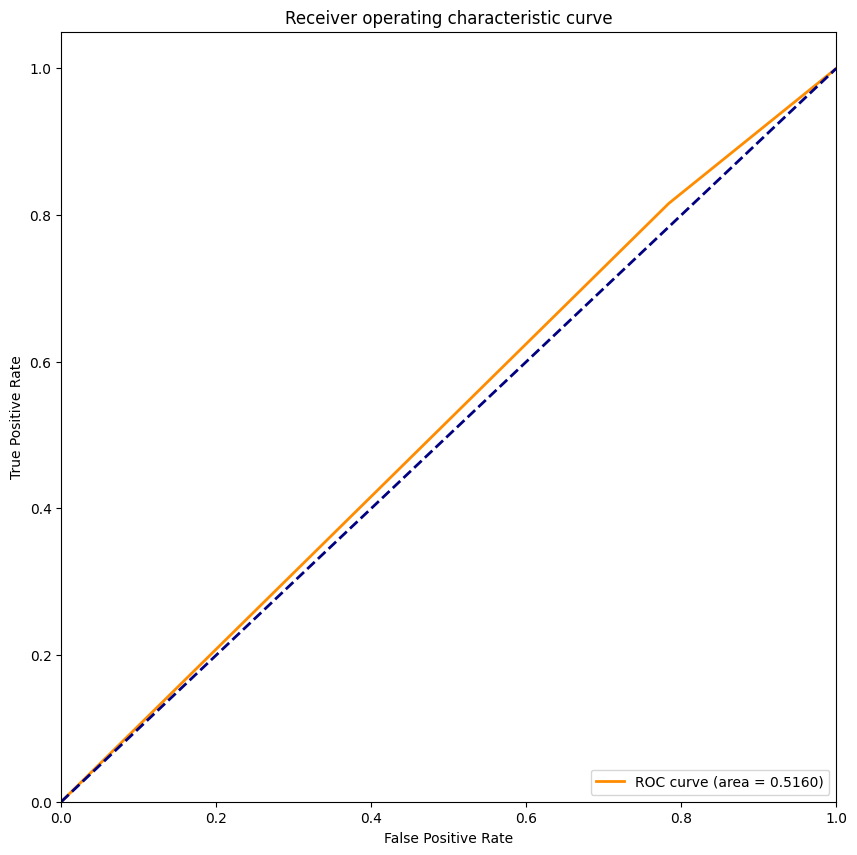

In [22]:
from sklearn.metrics import roc_curve, auc, roc_auc_score


# Prédire les probabilités pour les données de test
val = Dataset(cleaned_dev)
val_dataloader = torch.utils.data.DataLoader(val, batch_size = 16)
model = BertClassifier()

with torch.no_grad():
    y_pred = []
    y_true = []
    for inputs, labels in val_dataloader:
        labels = labels.unsqueeze(1).float()
        mask = inputs['attention_mask']
        input_id = inputs['input_ids'].squeeze(1)

        outputs = model(input_id, mask)

        probs = torch.nn.functional.softmax(outputs, dim = -1).squeeze(dim=0)
        class_probs = probs[:, 1]
        predicted_class_id = (class_probs > 0.5).float()

        y_pred.extend(predicted_class_id.numpy())
        y_true.extend(labels.numpy())


# Calculer l'AUC-ROC
auc_roc = roc_auc_score(y_true, y_pred)
print("AUC-ROC : {:.4f}".format(auc_roc))

# Calculer la courbe ROC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [22]:
torch.save(model.state_dict(), "best_model_sigm.pth")  # si on veut sauvegarder notre modèle avec les poids entraînés

In [ ]:
# Cellule pour regarder un peu comment ça se passe à l'intérieur de la boucle train + à quoi ressemble les input/output/label/mask...
# inutile de faire tourner
from tqdm import tqdm
model = BertClassifier()
train, val = Dataset(cleaned_train), Dataset(cleaned_dev)
batch_size=8

train_dataloader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val, batch_size)

loss = nn.BCEWithLogitsLoss()

with tf.device('/device:GPU:0'):
  for train_input, train_label in tqdm(train_dataloader):
    train_label = train_label.float()
    mask = train_input['attention_mask']
    input_id = train_input['input_ids'].squeeze(1)
    output = model(input_id, mask)
    print(train_label)
    print(output)
    probs = torch.nn.functional.softmax(output, dim = -1).squeeze(dim=0)
    print(probs)
    class_probs = probs[:, 1]
    print(class_probs)
    predicted_class_id = (class_probs > 0.5).float()
    print(predicted_class_id)
    vrai_positifs = 0
    for x in range(batch_size) :
      if (predicted_class_id[x] == train_label[x] == 1) :
        vrai_positifs += 1
    print(vrai_positifs)